# <center>CryptoCurrencies CA#2<center>
<h1><center>Transacting on Bitcoin TestNet / Firing up an Ethereum Node<center></h1>

#### <center>"Mohammadreza - Alavi"<center>
#### <center>"810100253"<center>

In [1]:
import os
import hashlib
import base58
import ecdsa
import base64

import requests

from bitcoin.core import b2x, lx, COIN, COutPoint, CMutableTxOut, CMutableTxIn, CMutableTransaction, Hash160
from bitcoin.core.script import *
from bitcoin.core.scripteval import VerifyScript, SCRIPT_VERIFY_P2SH

from bitcoin.core import COIN, b2lx, serialize, x, lx, b2x

### 1. Address Generation:

 1.1: Base58 and WIF address

In [19]:
def generate_private_key():
    private_key = os.urandom(32)
    return private_key.hex()

def private_key_to_wif(private_key):
    extended_key = 'ef' + private_key
    first_sha = hashlib.sha256(bytes.fromhex(extended_key)).hexdigest()
    second_sha = hashlib.sha256(bytes.fromhex(first_sha)).hexdigest()
    final_key = extended_key + second_sha[:8]
    wif = base58.b58encode(bytes.fromhex(final_key)).decode('utf-8')
    return wif

def private_key_to_public_key(private_key):
    private_key_bytes = bytes.fromhex(private_key)
    signing_key = ecdsa.SigningKey.from_string(private_key_bytes, curve=ecdsa.SECP256k1)
    verifying_key = signing_key.get_verifying_key()
    public_key = b'\x04' + verifying_key.to_string()
    return public_key.hex()

def public_key_to_address(public_key):
    sha256_public_key = hashlib.sha256(bytes.fromhex(public_key)).hexdigest()
    ripemd160 = hashlib.new('ripemd160')
    ripemd160.update(bytes.fromhex(sha256_public_key))
    ripemd160_public_key = ripemd160.hexdigest()
    extended_ripemd160 = '6f' + ripemd160_public_key
    first_sha = hashlib.sha256(bytes.fromhex(extended_ripemd160)).hexdigest()
    second_sha = hashlib.sha256(bytes.fromhex(first_sha)).hexdigest()
    final_address = extended_ripemd160 + second_sha[:8]
    address_base58 = base58.b58encode(bytes.fromhex(final_address)).decode('utf-8')
    return address_base58

# Generate private key
private_key = generate_private_key()
print("Private Key (hex):", private_key)

# Convert private key to WIF
wif = private_key_to_wif(private_key)
print("Private Key (WIF):", wif)

# Convert private key to public key
public_key = private_key_to_public_key(private_key)
print("Public Key:", public_key)

# Convert public key to Bitcoin address
address = public_key_to_address(public_key)
print("Bitcoin Address (Base85):", address)


Private Key (hex): 2db12c8768f9bca890c3fd420801256e029a65b6656ec0161d4380634d4da971
Private Key (WIF): 91w3JiLTT5fCiCMNbDEbd17crH4uE7BN4oSsQT3rgBboHMDrduH
Public Key: 041c65f218a3675604f21fac64b098e53e3246b8a0051fac8caf4ac55315e53dcf4828db2dc489704dc801121103896d424f60a88bda332d836ebfa434105dcd48
Bitcoin Address (Base85): mp6qXYiDPerq48m7dMArNCGmNUs2WmENZr


Differences between mainnet and testnet addresses: Mainnet addresses have actual value and start with "1" for P2PKH and with "3" for P2SH. Testnet addresses have no value and are used for testing and learning. they start with "m" or "n" for P2PKH and with "2" or "3" for P2SH.

1.2: Vanity Address Generator


In [23]:
def generate_address_with_prefix(prefix):
    while True:
        private_key = generate_private_key()
        public_key = private_key_to_public_key(private_key)
        address = public_key_to_address(public_key)
        if address[1:4] == prefix:
            wif = private_key_to_wif(private_key)
            return address, wif

prefix = "abc"

address, wif = generate_address_with_prefix(prefix)
print("Bitcoin Address (Base58):", address)
print("Private Key (WIF):", wif)


KeyboardInterrupt: 

### 2. Transacting on Bitcoin TestNet:

Here are some utility functions that you will need to use in order to make transactions. Fill the #TODO parts in the functions in order to be used in the next steps:

#### Utility Functions:

In [1]:
import bitcoin.wallet
from bitcoin.core import COIN, b2lx, serialize, x, lx, b2x
from utils import *

bitcoin.SelectParams("testnet")  # Select the network (testnet or mainnet)
# Private key in WIF format XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
my_private_key = bitcoin.wallet.CBitcoinSecret("91dw92EifWoxCd5zt4PtkHQVSHo6KDpTGS1yAstjEtkxpuamHzB")
my_public_key = my_private_key.pub
my_address = bitcoin.wallet.P2PKHBitcoinAddress.from_pubkey(my_public_key)
destination_address = bitcoin.wallet.CBitcoinAddress('XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX')  # Destination address (recipient of the money)


def P2PKH_scriptPubKey(address):
    ######################################################################
    ## Fill out the operations for P2PKH scriptPubKey                   ##

    return [OP_DUP, OP_HASH160, Hash160(address), OP_EQUALVERIFY, OP_CHECKSIG]
    ######################################################################


def P2PKH_scriptSig(txin, txout, txin_scriptPubKey):
    ######################################################################
    ## Fill out the operations for P2PKH scriptSig                      ##

    signature = create_OP_CHECKSIG_signature(txin, txout, txin_scriptPubKey, my_private_key)

    return [signature, my_public_key]  # Fill this section
    ######################################################################


def send_from_P2PKH_transaction(amount_to_send, txid_to_spend, utxo_index, txout_scriptPubKey):
    txout = create_txout(amount_to_send, txout_scriptPubKey)

    txin_scriptPubKey = P2PKH_scriptPubKey(my_address)
    txin = create_txin(txid_to_spend, utxo_index)
    txin_scriptSig = P2PKH_scriptSig(txin, txout, txin_scriptPubKey)

    new_tx = create_signed_transaction(txin, txout, txin_scriptPubKey, txin_scriptSig)

    return broadcast_transaction(new_tx)


def run():
    ######################################################################
    total = 0.0001789
    amount_to_send1 = 0.00002
    amount_to_send1 = 0.00003
    txid_to_spend = ('')  # TxHash of UTXO
    utxo_index = 0  # UTXO index among transaction outputs
    ######################################################################

    print(my_address)  # Prints your address in base58
    print(my_public_key.hex())  # Print your public key in hex
    print(my_private_key.hex())  # Print your private key in hex
    txout_scriptPubKey = P2PKH_scriptPubKey(my_address)
    response = send_from_P2PKH_transaction(amount_to_send, txid_to_spend, utxo_index, txout_scriptPubKey)
    print(response.status_code, response.reason)
    print(response.text)  # Report the hash of transaction which is printed in this section result


ModuleNotFoundError: No module named 'bitcoin.wallet'

In [2]:
def send_from_custom_transaction(amount_to_send, txid_to_spend, utxo_index,
                                 txin_scriptPubKey, txin_scriptSig, txout_scriptPubKey):
    txout = create_txout(amount_to_send, txout_scriptPubKey)
    txin = create_txin(txid_to_spend, utxo_index)
    new_tx = create_signed_transaction(txin, txout, txin_scriptPubKey, txin_scriptSig)
    return broadcast_transaction(new_tx)


def create_txin(txid, utxo_index) -> CMutableTxIn:
    return CMutableTxIn(COutPoint(lx(txid), utxo_index))


def create_txout(amount, scriptPubKey) -> CMutableTxOut:
    return CMutableTxOut(amount * COIN, CScript(scriptPubKey))


def create_OP_CHECKSIG_signature(txin, txout, txin_scriptPubKey, seckey):
    tx = CMutableTransaction([txin], txout)
    sighash = SignatureHash(CScript(txin_scriptPubKey), tx, 0, SIGHASH_ALL)
    sig = seckey.sign(sighash) + bytes([SIGHASH_ALL])
    return sig


def create_signed_transaction(txin, txout, txin_scriptPubKey, txin_scriptSig):
    tx = CMutableTransaction([txin], txout)
    txin.scriptSig = CScript(txin_scriptSig)
    VerifyScript(txin.scriptSig, CScript(txin_scriptPubKey),
                 tx, 0, (SCRIPT_VERIFY_P2SH,))
    return tx


def broadcast_transaction(tx):
    raw_transaction = b2x(tx.serialize())
    headers = {'content-type': 'application/x-www-form-urlencoded'}
    return requests.post(
        'https://api.blockcypher.com/v1/btc/test3/txs/push',
        headers=headers,
        data=f'{{"tx": "{raw_transaction}"}}'
    )


Now use the provided functions to make these transactions:

2.1: One input and two outputs transaction

Private Key (hex): 06d99e5c3a380352053b186f896dbdc1dc299dbc30553a75283b24b478843466 </br>
Private Key (WIF): 91dw92EifWoxCd5zt4PtkHQVSHo6KDpTGS1yAstjEtkxpuamHzB </br>
Public Key: 04300cf694a6095fd545acf0b22ad703645197c3fcbf426cd40315ca85ea042e32658e0a11329d0af5c2d1d3b0d6783664435cbc2fcad9cbbfa0b348984b5dc631 </br>
Bitcoin Address (Base85): mi8kWyLhma6zURUpjJAoF7zckaTQcgcgBT

In [6]:
import bitcoin.wallet
from bitcoin.core import COIN, b2lx, serialize, x, lx, b2x

bitcoin.SelectParams("testnet")  # Select the network (testnet or mainnet)
# Private key in WIF format XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
my_private_key = bitcoin.wallet.CBitcoinSecret("91dw92EifWoxCd5zt4PtkHQVSHo6KDpTGS1yAstjEtkxpuamHzB")
my_public_key = my_private_key.pub
my_address = bitcoin.wallet.P2PKHBitcoinAddress.from_pubkey(my_public_key)
destination_address = bitcoin.wallet.CBitcoinAddress('mi8kWyLhma6zURUpjJAoF7zckaTQcgcgBT')  # Destination address (recipient of the money)


def P2PKH_scriptPubKey(address):
    ######################################################################
    ## Fill out the operations for P2PKH scriptPubKey                   ##

    return [OP_DUP, OP_HASH160, Hash160(address), OP_EQUALVERIFY, OP_CHECKSIG]
    ######################################################################


def P2PKH_scriptSig(txin, txout, txin_scriptPubKey):
    ######################################################################
    ## Fill out the operations for P2PKH scriptSig                      ##

    signature = create_OP_CHECKSIG_signature(txin, txout, txin_scriptPubKey, my_private_key)

    return [signature, my_public_key]  # Fill this section
    ######################################################################

def get_txout_scriptPubKeys(amount_to_send1, amount_to_send2):
    txout1_scriptPubKey = [OP_TRUE]
    txout2_scriptPubKey = [OP_FALSE]
    txout1 = create_txout(amount_to_send1, txout1_scriptPubKey)
    txout2 = create_txout(amount_to_send2, txout2_scriptPubKey)
    return txout1, txout2

def send_from_P2PKH_transaction(amount_to_send1, amount_to_send2, txid_to_spend, utxo_index):
    txout1 = create_txout(amount_to_send1, [OP_TRUE])
    txout2 = create_txout(amount_to_send2, [OP_FALSE])

    txin = create_txin(txid_to_spend, utxo_index)
    txin_scriptPubKey = P2PKH_scriptPubKey(my_public_key)
    txin_scriptSig = P2PKH_scriptSig(txin, [txout1, txout2], txin_scriptPubKey)

    new_tx = create_signed_transaction(txin, [txout1, txout2], txin_scriptPubKey, txin_scriptSig)
    return broadcast_transaction(new_tx)


def run():
    ######################################################################
    total = 0.00011141
    amount_to_send1 = 0.0000114
    amount_to_send2 = 0.00000001
    transaction_fee = 0.0001
    txid_to_spend = ('f9a2020dfac952ff39ff94960b10387959e8b0bf8077cc3f863aab389074ce5b')  # TxHash of UTXO
    utxo_index = 1  # UTXO index among transaction outputs
    ######################################################################

    print(my_address)  # Prints your address in base58
    print(my_public_key.hex())  # Print your public key in hex
    print(my_private_key.hex())  # Print your private key in hex
    response = send_from_P2PKH_transaction(amount_to_send1, amount_to_send2, txid_to_spend, utxo_index)
    print(response.status_code, response.reason)
    print(response.text)  # Report the hash of transaction which is printed in this section result

run()

mi8kWyLhma6zURUpjJAoF7zckaTQcgcgBT
04300cf694a6095fd545acf0b22ad703645197c3fcbf426cd40315ca85ea042e32658e0a11329d0af5c2d1d3b0d6783664435cbc2fcad9cbbfa0b348984b5dc631
06d99e5c3a380352053b186f896dbdc1dc299dbc30553a75283b24b478843466
201 Created
{
  "tx": {
    "block_height": -1,
    "block_index": -1,
    "hash": "2e64d7d44ca2b3e1da1710e0aced689d3fc555ac5e2f57418d767937c1650cd7",
    "addresses": [
      "mi8kWyLhma6zURUpjJAoF7zckaTQcgcgBT"
    ],
    "total": 1141,
    "fees": 10000,
    "size": 210,
    "vsize": 210,
    "preference": "low",
    "relayed_by": "188.118.96.51",
    "received": "2024-05-29T12:30:31.962547419Z",
    "ver": 1,
    "double_spend": false,
    "vin_sz": 1,
    "vout_sz": 2,
    "confirmations": 0,
    "inputs": [
      {
        "prev_hash": "f9a2020dfac952ff39ff94960b10387959e8b0bf8077cc3f863aab389074ce5b",
        "output_index": 1,
        "script": "483045022100d8959b1d4bc4027247ea2b337b7b24a0a788bbf3d15b74b38d6b23e7ddf847aa0220609e0bef3eb2b07753cbba0b2cf

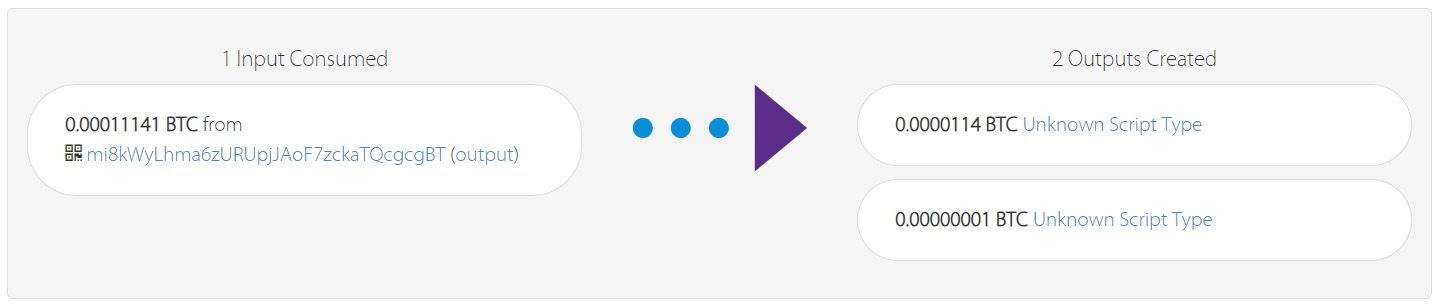

In [8]:
def send_from_P2PKH_transaction(amount_to_send, txid_to_spend, utxo_index):
    txout_scriptPubKey = P2PKH_scriptPubKey(my_public_key)
    txout = create_txout(amount_to_send, txout_scriptPubKey)
    txin = create_txin(txid_to_spend, utxo_index)
    txin_scriptPubKey = [OP_TRUE]
    txin_scriptSig = []
    new_tx = create_signed_transaction(txin, [txout], txin_scriptPubKey, txin_scriptSig)
    return broadcast_transaction(new_tx)

def run():
    ######################################################################
    total = 0.0000114
    amount_to_send = 0.0000014
    fee = 0.00001
    txid_to_spend = ('2e64d7d44ca2b3e1da1710e0aced689d3fc555ac5e2f57418d767937c1650cd7')  # TxHash of UTXO
    utxo_index = 0  # UTXO index among transaction outputs
    ######################################################################

    print(my_address)  # Prints your address in base58
    print(my_public_key.hex())  # Print your public key in hex
    print(my_private_key.hex())  # Print your private key in hex
    txout_scriptPubKey = P2PKH_scriptPubKey(my_address)
    response = send_from_P2PKH_transaction(amount_to_send, txid_to_spend, utxo_index)
    print(response.status_code, response.reason)
    print(response.text)  # Report the hash of transaction which is printed in this section result

run()

mi8kWyLhma6zURUpjJAoF7zckaTQcgcgBT
04300cf694a6095fd545acf0b22ad703645197c3fcbf426cd40315ca85ea042e32658e0a11329d0af5c2d1d3b0d6783664435cbc2fcad9cbbfa0b348984b5dc631
06d99e5c3a380352053b186f896dbdc1dc299dbc30553a75283b24b478843466
201 Created
{
  "tx": {
    "block_height": -1,
    "block_index": -1,
    "hash": "4bb00eb739ed0523ef20fda916364774075a4d0588f3e27384698a09ca712fa0",
    "addresses": [
      "mi8kWyLhma6zURUpjJAoF7zckaTQcgcgBT"
    ],
    "total": 140,
    "fees": 1000,
    "size": 85,
    "vsize": 85,
    "preference": "low",
    "relayed_by": "188.118.96.51",
    "received": "2024-05-29T13:15:06.459362406Z",
    "ver": 1,
    "double_spend": false,
    "vin_sz": 1,
    "vout_sz": 1,
    "confirmations": 0,
    "inputs": [
      {
        "prev_hash": "2e64d7d44ca2b3e1da1710e0aced689d3fc555ac5e2f57418d767937c1650cd7",
        "output_index": 0,
        "output_value": 1140,
        "sequence": 4294967295,
        "script_type": "unknown",
        "age": 0
      }
    ],
  

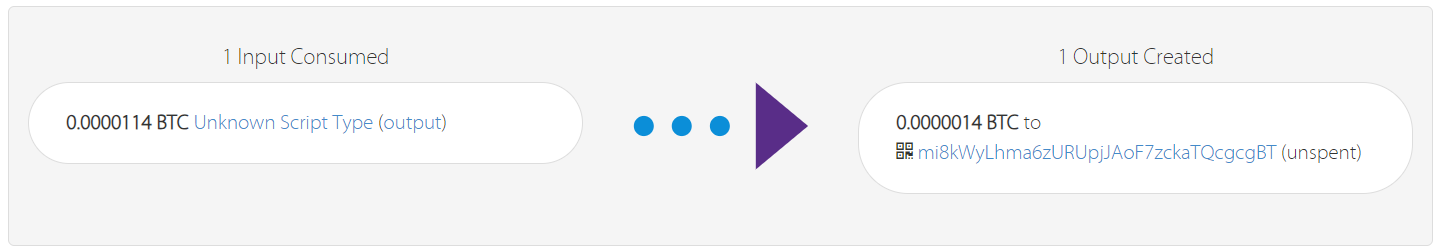

2.2: Pay to MultiSig transaction (P2MS)


Private Key (hex): 3918831b2675c28dd38ec4fb47955689562e1fd7cfc90246d3e7bf7fee7ed68f </br>
Private Key (WIF): 9224bcJyizUrxqL13Yi2cwwnqNmXRHaobn3bqH1i8k9As3BjXRR </br>
Public Key: 041c7ff92ff7c5c2b915bba95309de8ac2d19674179ed2d8ed966d7eef9b00c225f3fa653b5ebca4b58950f264e18fc9f1d12ced5a389494ebc13d6ec6394d053a </br>
Bitcoin Address (Base85): mxWaDEUfkKhZEpt8d5J46bUzLNGPavF8iu </br> </br>

Private Key (hex): ef036d61bee6fedded601109aabcb15bd25a5fe96d26ac42f18a3e9f1fc50713 </br>
Private Key (WIF): 93QBSSQmkWaKqztgG7Sn6zWMMtoG2uJdkJM5Ri41xcNLCMpHKGP </br>
Public Key: 0452f56a186a21ba3afe20d9e50d859a0efffe813934e18189dc4a49517b1753fab8f861cdce936c617a7b24242ff6acd790441caa865d2fca3c41ac8ecf458449 </br>
Bitcoin Address (Base85): mxixC95cyHB86a7r1cW9WzzY3UevTfVo2q </br> </br>

Private Key (hex): 214ea7b60941e429a6d192049219d27aa789d409746506e04e9d0a01f5edecf2 </br>
Private Key (WIF): 91qaxBAYUnaKCnfHWfvZFQ7LNYSz4Rj7eXceWeuNrzXg1mUq4e4 </br>
Public Key: 04d94771416abc5d96d4d2b62c8e6a765d96220d7132deb2239f7694ba171cfbc07178fa1d5e15196340370cc4c381f76268c2786cc324a94b1ade3e7c91515f3f </br>
Bitcoin Address (Base85): mfi5wBqwP7jaYbNauzPZtdseMfaKZcG6mq </br> </br>

Private Key (hex): 1cab9aa1fbd3712c52466d4a98de18552d1762636551df9b1fc176f6ad9bb3b1 </br>
Private Key (WIF): 91oYWS39GFAMpYvLyBp7yjbkGUuyyJ9sbUdRjoW6qt2THc9QCVN </br>
Public Key: 04b6ee4013b2e923a88b1ffc68afb38f9ec69c8757c3cfe4dace4ec995d81efe065ae6c47e964de3341371452e3abaccb1276f1acf7a7581c44c3e65d3e2376ec9 </br>
Bitcoin Address (Base85): mnU7QEZQMKUmxpEeq4ZEMJ95CybnrSYwJf

In [21]:
bitcoin.SelectParams("testnet")  # Select the network (testnet or mainnet)
# Private key in WIF format XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
my_private_key = bitcoin.wallet.CBitcoinSecret("9224bcJyizUrxqL13Yi2cwwnqNmXRHaobn3bqH1i8k9As3BjXRR")
private_key1 = bitcoin.wallet.CBitcoinSecret("93QBSSQmkWaKqztgG7Sn6zWMMtoG2uJdkJM5Ri41xcNLCMpHKGP")
private_key2 = bitcoin.wallet.CBitcoinSecret("91qaxBAYUnaKCnfHWfvZFQ7LNYSz4Rj7eXceWeuNrzXg1mUq4e4")
private_key3 = bitcoin.wallet.CBitcoinSecret("91oYWS39GFAMpYvLyBp7yjbkGUuyyJ9sbUdRjoW6qt2THc9QCVN")
my_public_key = my_private_key.pub
public_key1 = private_key1.pub
public_key2 = private_key2.pub
public_key3 = private_key3.pub
my_address = bitcoin.wallet.P2PKHBitcoinAddress.from_pubkey(my_public_key)
destination_address = bitcoin.wallet.CBitcoinAddress('mxWaDEUfkKhZEpt8d5J46bUzLNGPavF8iu')  # Destination address (recipient of the money)

def send_from_P2PKH_transaction(amount_to_send, txid_to_spend, utxo_index):
    txout_scriptPubKey = [OP_2, public_key1, public_key2, public_key3, OP_3, OP_CHECKMULTISIG]
    txout = create_txout(amount_to_send, txout_scriptPubKey)
    txin = create_txin(txid_to_spend, utxo_index)
    txin_scriptPubKey = P2PKH_scriptPubKey(my_public_key)
    txin_scriptSig = P2PKH_scriptSig(txin, [txout], txin_scriptPubKey)
    new_tx = create_signed_transaction(txin, [txout], txin_scriptPubKey, txin_scriptSig)
    return broadcast_transaction(new_tx)

def run():
    ######################################################################
    total = 0.00016416
    amount_to_send = 0.00006416
    transaction_fee = 0.0001
    txid_to_spend = ('a9163192127e0ac88e09ebb97ad3d8046d8a814416ab25101aaacb54be7db853')  # TxHash of UTXO
    utxo_index = 1  # UTXO index among transaction outputs
    ######################################################################

    print(my_address)  # Prints your address in base58
    print(my_public_key.hex())  # Print your public key in hex
    print(my_private_key.hex())  # Print your private key in hex
    response = send_from_P2PKH_transaction(amount_to_send, txid_to_spend, utxo_index)
    print(response.status_code, response.reason)
    print(response.text)  # Report the hash of transaction which is printed in this section result

run()

mxWaDEUfkKhZEpt8d5J46bUzLNGPavF8iu
041c7ff92ff7c5c2b915bba95309de8ac2d19674179ed2d8ed966d7eef9b00c225f3fa653b5ebca4b58950f264e18fc9f1d12ced5a389494ebc13d6ec6394d053a
3918831b2675c28dd38ec4fb47955689562e1fd7cfc90246d3e7bf7fee7ed68f
201 Created
{
  "tx": {
    "block_height": -1,
    "block_index": -1,
    "hash": "dfe1d3ad8f00ba495a93e535acbd32a4aeed7921ccd3732cecc1b7b5dd907284",
    "addresses": [
      "mxWaDEUfkKhZEpt8d5J46bUzLNGPavF8iu",
      "zTP7oT7ArTGWdzYiiUCCM93bZvj2kR9KXU"
    ],
    "total": 6416,
    "fees": 10000,
    "size": 399,
    "vsize": 399,
    "preference": "low",
    "relayed_by": "188.118.96.51",
    "received": "2024-05-29T14:36:10.778616239Z",
    "ver": 1,
    "double_spend": false,
    "vin_sz": 1,
    "vout_sz": 1,
    "confirmations": 0,
    "inputs": [
      {
        "prev_hash": "a9163192127e0ac88e09ebb97ad3d8046d8a814416ab25101aaacb54be7db853",
        "output_index": 1,
        "script": "47304402207a89e1edc25cb2b65f3d514e8d71d658a62d01731beed78ede499

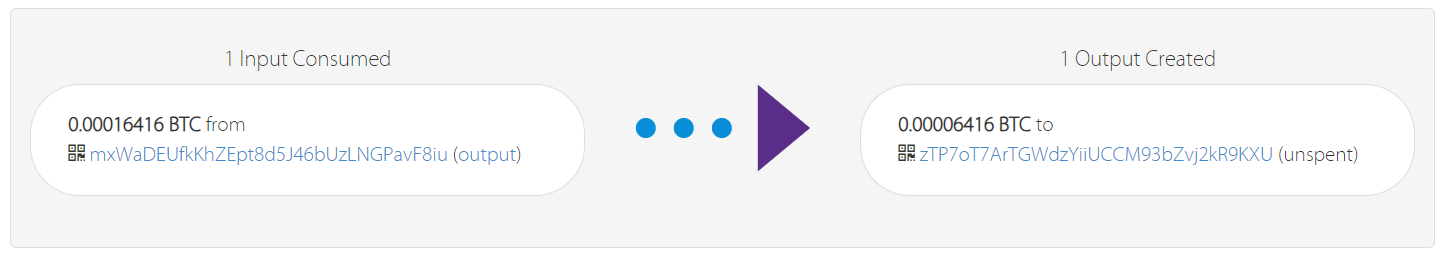

In [22]:
def P2PKH_scriptSig(txin, txout, txin_scriptPubKey):
    ######################################################################
    ## Fill out the operations for P2PKH scriptSig                      ##

    signature1 = create_OP_CHECKSIG_signature(txin, txout, txin_scriptPubKey, private_key1)
    signature2 = create_OP_CHECKSIG_signature(txin, txout, txin_scriptPubKey, private_key2)
    return [OP_FALSE, signature1, signature2]  # Fill this section
    ######################################################################

def scriptSig(txin, txout, txin_scriptPubKey):
    signature1 = create_OP_CHECKSIG_signature(txin, txout, txin_scriptPubKey, private_key1)
    signature2 = create_OP_CHECKSIG_signature(txin, txout, txin_scriptPubKey, private_key2)
    return [OP_0, signature1, signature2]

def send_from_P2PKH_transaction(amount_to_send, txid_to_spend, utxo_index):
    txout_scriptPubKey = P2PKH_scriptPubKey(my_public_key)
    txout = create_txout(amount_to_send, txout_scriptPubKey)
    txin = create_txin(txid_to_spend, utxo_index)
    txin_scriptPubKey = [OP_2, public_key1, public_key2, public_key3, OP_3, OP_CHECKMULTISIG]
    txin_scriptSig = P2PKH_scriptSig(txin, [txout], txin_scriptPubKey)
    new_tx = create_signed_transaction(txin, [txout], txin_scriptPubKey, txin_scriptSig)
    return broadcast_transaction(new_tx)

def run():
    ######################################################################
    total = 0.00006416
    amount_to_send = 0.00000416
    transaction_fee = 0.00006
    txid_to_spend = ('dfe1d3ad8f00ba495a93e535acbd32a4aeed7921ccd3732cecc1b7b5dd907284')  # TxHash of UTXO
    utxo_index = 0  # UTXO index among transaction outputs
    ######################################################################

    print(my_address)  # Prints your address in base58
    print(my_public_key.hex())  # Print your public key in hex
    print(my_private_key.hex())  # Print your private key in hex
    response = send_from_P2PKH_transaction(amount_to_send, txid_to_spend, utxo_index)
    print(response.status_code, response.reason)
    print(response.text)  # Report the hash of transaction which is printed in this section result

run()

mxWaDEUfkKhZEpt8d5J46bUzLNGPavF8iu
041c7ff92ff7c5c2b915bba95309de8ac2d19674179ed2d8ed966d7eef9b00c225f3fa653b5ebca4b58950f264e18fc9f1d12ced5a389494ebc13d6ec6394d053a
3918831b2675c28dd38ec4fb47955689562e1fd7cfc90246d3e7bf7fee7ed68f
201 Created
{
  "tx": {
    "block_height": -1,
    "block_index": -1,
    "hash": "191b93af7bb8cd387ab8e0da183c14104b20bb467a1a0e558aa01d927bc73eeb",
    "addresses": [
      "zTP7oT7ArTGWdzYiiUCCM93bZvj2kR9KXU",
      "mxWaDEUfkKhZEpt8d5J46bUzLNGPavF8iu"
    ],
    "total": 416,
    "fees": 6000,
    "size": 232,
    "vsize": 232,
    "preference": "low",
    "relayed_by": "188.118.96.51",
    "received": "2024-05-29T14:39:49.219537921Z",
    "ver": 1,
    "double_spend": false,
    "vin_sz": 1,
    "vout_sz": 1,
    "confirmations": 0,
    "inputs": [
      {
        "prev_hash": "dfe1d3ad8f00ba495a93e535acbd32a4aeed7921ccd3732cecc1b7b5dd907284",
        "output_index": 0,
        "script": "00483045022100bc10cee0c8fb96c3a88aa77d91f0ac482f21cdf6d1e8beb95b2

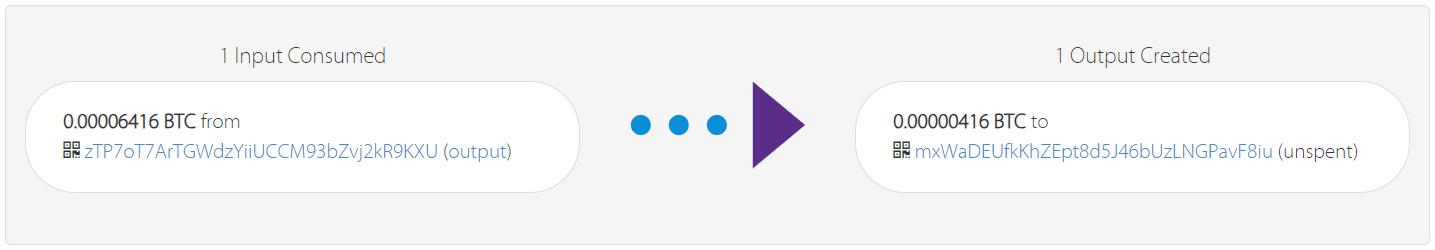

2.3: Custom Transaction (BitCoin Scripting)


Private Key (hex): 2db12c8768f9bca890c3fd420801256e029a65b6656ec0161d4380634d4da971 </br>
Private Key (WIF): 91w3JiLTT5fCiCMNbDEbd17crH4uE7BN4oSsQT3rgBboHMDrduH </br>
Public Key: 041c65f218a3675604f21fac64b098e53e3246b8a0051fac8caf4ac55315e53dcf4828db2dc489704dc801121103896d424f60a88bda332d836ebfa434105dcd48 </br>
Bitcoin Address (Base85): mp6qXYiDPerq48m7dMArNCGmNUs2WmENZr

In [20]:
bitcoin.SelectParams("testnet")  # Select the network (testnet or mainnet)
# Private key in WIF format XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
my_private_key = bitcoin.wallet.CBitcoinSecret("91w3JiLTT5fCiCMNbDEbd17crH4uE7BN4oSsQT3rgBboHMDrduH")
my_public_key = my_private_key.pub
my_address = bitcoin.wallet.P2PKHBitcoinAddress.from_pubkey(my_public_key)
destination_address = bitcoin.wallet.CBitcoinAddress('mp6qXYiDPerq48m7dMArNCGmNUs2WmENZr')

PASSWORD = 810100253

def send_P2PKH_tx(amount_to_spend, txid_to_spend, utxo_index, txout_scriptPubKey):
    txin = create_txin(txid_to_spend, utxo_index)
    txout = create_txout(amount_to_spend, txout_scriptPubKey)

    txin_scriptPubKey = P2PKH_scriptPubKey(my_public_key)
    txin_scriptSig = P2PKH_scriptSig(txin, [txout], txin_scriptPubKey, my_private_key, my_public_key)
    tx = create_signed_transaction(txin, [txout], txin_scriptPubKey, txin_scriptSig)

    return broadcast_transaction(tx)

total = 0.00019492
amount_to_spend = 0.00009492
transaction_fee = 0.0001
txid_to_spend = ('1e7cc21a5c3202b92d170a5b1b198bcde5e530578db02f4416389ff826f77b0a')
utxo_index = 1
txout_scriptPubKey = [OP_SUB, 18 , OP_GREATERTHAN, OP_IF, OP_DROP, OP_TRUE, OP_ELSE, OP_HASH160, 
                      Hash160(PASSWORD.to_bytes(4, byteorder="little")), OP_EQUAL, OP_ENDIF]
print(my_address)  # Prints your address in base58
print(my_public_key.hex())  # Print your public key in hex
print(my_private_key.hex())  # Print your private key in hex
response = send_P2PKH_tx(amount_to_spend, txid_to_spend, utxo_index, txout_scriptPubKey)
print(response.status_code, response.reason)
print(response.text)  # Report the hash of transaction which is printed in this section result

mp6qXYiDPerq48m7dMArNCGmNUs2WmENZr
041c65f218a3675604f21fac64b098e53e3246b8a0051fac8caf4ac55315e53dcf4828db2dc489704dc801121103896d424f60a88bda332d836ebfa434105dcd48
2db12c8768f9bca890c3fd420801256e029a65b6656ec0161d4380634d4da971
201 Created
{
  "tx": {
    "block_height": -1,
    "block_index": -1,
    "hash": "740908a71bcbd3726c441ac5afb261e4333e5c08a49c3f7d098a42bf6876292e",
    "addresses": [
      "mp6qXYiDPerq48m7dMArNCGmNUs2WmENZr"
    ],
    "total": 9492,
    "fees": 10000,
    "size": 230,
    "vsize": 230,
    "preference": "low",
    "relayed_by": "51.75.23.31",
    "received": "2024-05-30T07:30:32.507759193Z",
    "ver": 1,
    "double_spend": false,
    "vin_sz": 1,
    "vout_sz": 1,
    "confirmations": 0,
    "inputs": [
      {
        "prev_hash": "1e7cc21a5c3202b92d170a5b1b198bcde5e530578db02f4416389ff826f77b0a",
        "output_index": 1,
        "script": "473044022068551df057538997e455bda429f978279896ec9137ab25428265b3eaa967d37902204c4d3a940345d0f8859bcb7bd1f251e

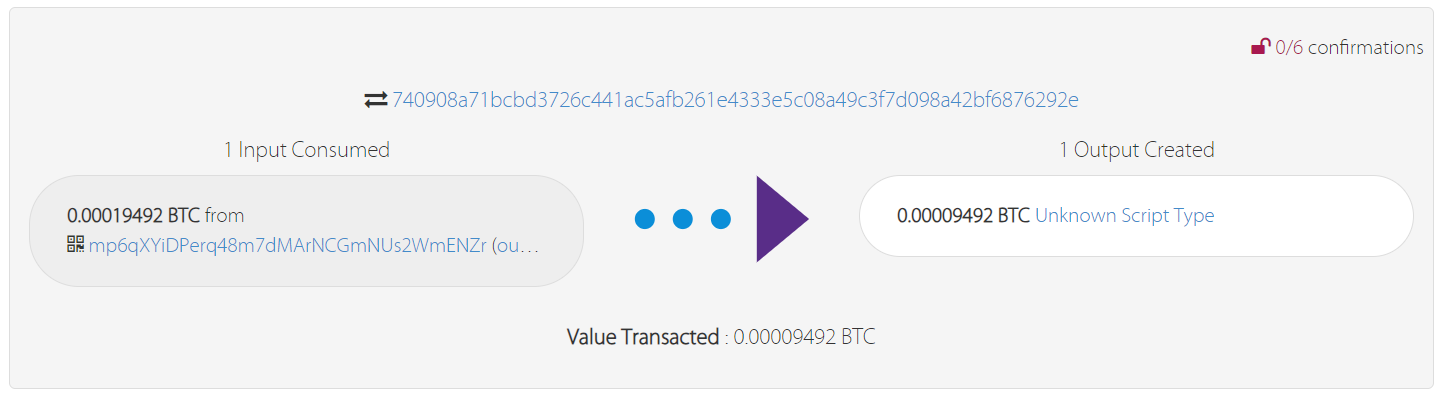

In [21]:
BIRTH_YEAR = 2002
CURR_YEAR = 2024
PASSWORD = 810100253
NEW_PASSWORD = 810100254

def send_P2PKH_tx(amount_to_spend, txid_to_spend, utxo_index, txout_scriptPubKey):
    txin = create_txin(txid_to_spend, utxo_index)
    txout = create_txout(amount_to_spend, txout_scriptPubKey)

    txin_scriptPubKey = [OP_SUB, 18 , OP_GREATERTHAN, OP_IF, OP_DROP, OP_TRUE, OP_ELSE, OP_HASH160, 
                      Hash160(PASSWORD.to_bytes(4, byteorder="little")), OP_EQUAL, OP_ENDIF]
    txin_scriptSig = [NEW_PASSWORD, CURR_YEAR, BIRTH_YEAR]
    tx = create_signed_transaction(txin, [txout], txin_scriptPubKey, txin_scriptSig)

    return broadcast_transaction(tx)

total = 0.00009492
amount_to_spend = 0.00004492
transaction_fee = 0.00005
txid_to_spend = ('740908a71bcbd3726c441ac5afb261e4333e5c08a49c3f7d098a42bf6876292e')
utxo_index = 0
txout_scriptPubKey = [OP_SUB, 18 , OP_GREATERTHAN, OP_IF, OP_DROP, OP_TRUE, OP_ELSE, OP_HASH160, 
                      Hash160(PASSWORD.to_bytes(4, byteorder="little")), OP_EQUAL, OP_ENDIF]
print(my_address)  # Prints your address in base58
print(my_public_key.hex())  # Print your public key in hex
print(my_private_key.hex())  # Print your private key in hex
response = send_P2PKH_tx(amount_to_spend, txid_to_spend, utxo_index, txout_scriptPubKey)
print(response.status_code, response.reason)
print(response.text)  # Report the hash of transaction which is printed in this section result

mp6qXYiDPerq48m7dMArNCGmNUs2WmENZr
041c65f218a3675604f21fac64b098e53e3246b8a0051fac8caf4ac55315e53dcf4828db2dc489704dc801121103896d424f60a88bda332d836ebfa434105dcd48
2db12c8768f9bca890c3fd420801256e029a65b6656ec0161d4380634d4da971
201 Created
{
  "tx": {
    "block_height": -1,
    "block_index": -1,
    "hash": "d33a4f33d4eead351b8c5c893466a688996e850c92ebe61d6fe1e5d2b671da9c",
    "addresses": [],
    "total": 4492,
    "fees": 5000,
    "size": 103,
    "vsize": 103,
    "preference": "low",
    "relayed_by": "51.75.23.31",
    "received": "2024-05-30T07:32:54.610104653Z",
    "ver": 1,
    "double_spend": false,
    "vin_sz": 1,
    "vout_sz": 1,
    "confirmations": 0,
    "inputs": [
      {
        "prev_hash": "740908a71bcbd3726c441ac5afb261e4333e5c08a49c3f7d098a42bf6876292e",
        "output_index": 0,
        "script": "041e26493002e80702d207",
        "output_value": 9492,
        "sequence": 4294967295,
        "script_type": "unknown",
        "age": 0
      }
    ],
    "

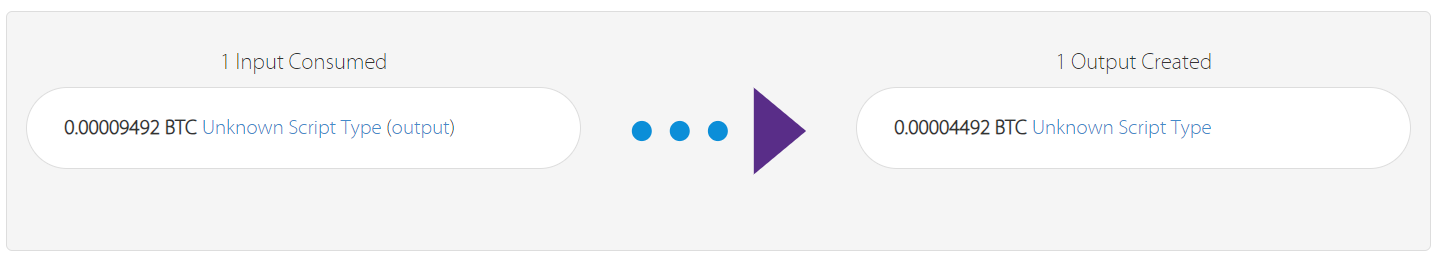

In [22]:
def send_P2PKH_tx(amount_to_spend, txid_to_spend, utxo_index, txout_scriptPubKey):
    txin = create_txin(txid_to_spend, utxo_index)
    txout = create_txout(amount_to_spend, txout_scriptPubKey)

    txin_scriptPubKey = [OP_SUB, 18 , OP_GREATERTHAN, OP_IF, OP_DROP, OP_TRUE, OP_ELSE, OP_HASH160, 
                      Hash160(PASSWORD.to_bytes(4, byteorder="little")), OP_EQUAL, OP_ENDIF]
    txin_scriptSig = [NEW_PASSWORD, CURR_YEAR, BIRTH_YEAR]
    tx = create_signed_transaction(txin, [txout], txin_scriptPubKey, txin_scriptSig)

    return broadcast_transaction(tx)

total = 0.00004492
amount_to_spend = 0.00000492
transaction_fee = 0.00004
txid_to_spend = ('d33a4f33d4eead351b8c5c893466a688996e850c92ebe61d6fe1e5d2b671da9c')
utxo_index = 0
txout_scriptPubKey = [OP_SUB, 18 , OP_GREATERTHAN, OP_IF, OP_DROP, OP_TRUE, OP_ELSE, OP_HASH160, 
                      Hash160(PASSWORD.to_bytes(4, byteorder="little")), OP_EQUAL, OP_ENDIF]
print(my_address)  # Prints your address in base58
print(my_public_key.hex())  # Print your public key in hex
print(my_private_key.hex())  # Print your private key in hex
response = send_P2PKH_tx(amount_to_spend, txid_to_spend, utxo_index, txout_scriptPubKey)
print(response.status_code, response.reason)
print(response.text)  # Report the hash of transaction which is printed in this section result

mp6qXYiDPerq48m7dMArNCGmNUs2WmENZr
041c65f218a3675604f21fac64b098e53e3246b8a0051fac8caf4ac55315e53dcf4828db2dc489704dc801121103896d424f60a88bda332d836ebfa434105dcd48
2db12c8768f9bca890c3fd420801256e029a65b6656ec0161d4380634d4da971
201 Created
{
  "tx": {
    "block_height": -1,
    "block_index": -1,
    "hash": "7cf8f26341c2af2961ee2b57df11cb5360b7dfe76dfd7174a31c5f1328af84ae",
    "addresses": [],
    "total": 492,
    "fees": 4000,
    "size": 103,
    "vsize": 103,
    "preference": "low",
    "relayed_by": "86.107.154.91",
    "received": "2024-05-30T07:42:04.408082514Z",
    "ver": 1,
    "double_spend": false,
    "vin_sz": 1,
    "vout_sz": 1,
    "confirmations": 0,
    "inputs": [
      {
        "prev_hash": "d33a4f33d4eead351b8c5c893466a688996e850c92ebe61d6fe1e5d2b671da9c",
        "output_index": 0,
        "script": "041d26493002e80702de07",
        "output_value": 4492,
        "sequence": 4294967295,
        "script_type": "unknown",
        "age": 0
      }
    ],
    

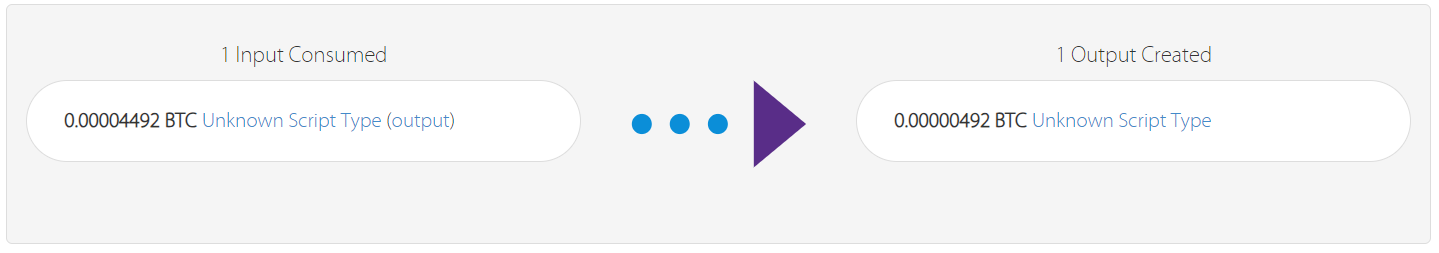

Q1

Proof of Burn (PoB): Proof of Burn (PoB) is a consensus algorithm used in some blockchain networks. It is an alternative to Proof of Work (PoW) and Proof of Stake (PoS). PoB involves participants "burning" (destroying) their cryptocurrency tokens to gain the right to mine or validate transactions on the network. </br>
Advantages: Environmental impact - Decentralization - Fairness </br>
Disadvantages: Waste of resources - Economic inefficiency - Security risks </br>

Burning coins in a cryptocurrency network can economically contribute to the stability and value of the network. Here’s how: </br>

1. Reducing Supply and Increasing Scarcity: Burning coins permanently reduces the total number of coins in circulation. When supply decreases while demand remains constant or increases, the value of the remaining coins typically rises. This phenomenon is similar to deflation, which increases the value of an asset. </br>

2. Boosting Trust and Attracting Investment Burning coins signals participants' confidence in the network's future. This confidence can attract more investors and increase overall investment in the network, contributing to its stability and value growth. </br>

3. Decreasing Price Volatility With fewer coins available for trading, the market is less susceptible to large fluctuations, leading to reduced price volatility. This stability helps maintain the value of the cryptocurrency, as sudden price changes become less frequent. </br>

4. Long-Term Incentives Burning coins encourages participants to think long-term rather than seeking short-term gains. This commitment to the network enhances its security and stability, positively impacting the cryptocurrency's long-term value. </br>

Q2

Bitcoin's scripting language, known as Bitcoin Script, is deliberately not Turing Complete. It is stack-based language. This scripting language is designed to perform simple and secure operations, avoiding computational complexity and security risks. </br>

Advantages: </br>
Greater Flexibility: A Turing Complete language can execute more complex programs, adding more capabilities to the network. This flexibility allows developers to design more sophisticated smart contracts. </br>
Broader Application Development: With a Turing Complete language, a wider range of applications can be implemented on the blockchain, including decentralized finance (DeFi), games, and other use cases. </br>
Creative Development: Developers can be more creative and develop innovative solutions to various problems since there are fewer restrictions in the language. </br>
Disadvantages: </br>
Complexity and Security Risks: Turing Complete languages can lead to complex bugs and security vulnerabilities. Sophisticated smart contracts might contain programming errors that could result in malicious attacks. </br>
Higher Computational Costs: Executing complex programs requires more computational resources, which can increase execution costs and processing time. This could lead to higher fees and slower network performance. </br>
Harder Implementation: Developing and implementing Turing Complete languages is more challenging and requires more knowledge and experience from developers. This can increase development time and costs.